# Advection-diffusion 1D
***
Created by: Juan Felipe Osorio Ramirez

Department of Applied Mathematics, UW
***

$\partial_t u = c^2\partial_{xx}u - \beta u_x$ 

subject to zero Dirichlet boundary conditions. Its analytical solution is given by 

\begin{align*}
u(x,t)=e^{\frac{-\beta^2 t}{4c^2}} e^{\frac{\beta x}{2c^2}} \sum_{n=1}^{\infty} b_n \sin \left(n \pi x\right) e^{-c^2\left(n \pi\right)^2 t}    
\end{align*}
where $b_n$ are found imposing the initial condition to get 
\begin{align*}
    b_n=2 \int_0^1 e^{-\frac{\beta x}{2c^2}} \left(-4\left(x-0.5\right)^{2}+1\right) \sin \left(n \pi x\right)  \mathrm{d} x
\end{align*}


## Libraries

In [89]:
import sys
sys.path.append('/Users/josorior/Documents/UW/research/kinetick/kinetick/source')

In [90]:
import jax.numpy as np
from jax import grad, jit
from jax.scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from interpolation import *
from kernels import *
from integrate import trap
from sklearn.metrics import mean_squared_error

import jax.numpy as jnp
from jax import grad, jit
from jax.config import config; 
from numpy.linalg import norm
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

## Utils

In [91]:
def Kphiphi_assembly(Xomega, Xboundary , h, b, c, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian
  if k == 'Matern1':
    kernel = Matern_Kernel_1

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,M))

  # Block 1,1 
  val1 = K(kernel, Xomega, Xomega, k_param) # K(X,X)
  val2 = K_dot(kernel, Xomega, Xomega, k_param, 0) # D1 K(X,X)
  val3 = K_dot(kernel, Xomega, Xomega, k_param, 1) # D1 K(X,X)
  #val3 = val2 # D2 K(X,X)
  val4 = K_ddot(kernel, Xomega, Xomega, k_param, 0, 0) # D1D1 K(X,X)
  val5 = K_ddot(kernel, Xomega, Xomega, k_param, 1, 1) # D1D1 K(X,X)
  #val5 = val4 # D2D2 K(X,X)
  val6 = K_ddot(kernel, Xomega, Xomega, k_param, 0, 1) # D2D1 K(X,X)
  val7 = K_dddot(kernel, Xomega, Xomega, k_param, 0, 1, 1) # D2D2 D1 K(X,X)
  val8 = K_dddot(kernel, Xomega, Xomega, k_param, 0, 0, 1) # D2 D1D1 K(X,X)
  val9 = K_ddddot(kernel, Xomega, Xomega, k_param, 0, 0, 1, 1) # D2D2 D1D1 K(X,X)
  val = val1-h*(c**2)*val4+b*h*val2 -h*(c**2)*(val5-h*(c**2)*val9+b*h*val7) +b*h*(val3-h*(c**2)*val8+b*h*val6)
  Theta = Theta.at[:Momega, :Momega].set(val)

  # Block 1,2
  val1 = K(kernel, Xomega, Xboundary, k_param)
  val4 = K_ddot(kernel, Xomega, Xboundary, k_param, 0, 0)
  val2 = K_dot(kernel, Xomega, Xboundary, k_param, 0)
  val = val1-h*(c**2)*val4+b*h*val2
  Theta = Theta.at[:Momega, Momega:].set(val)
  Theta = Theta.at[Momega:, :Momega].set(jnp.transpose(val)) # Block 2,1

  # Block 2,2
  val = K(kernel, Xboundary , Xboundary, k_param)
  Theta = Theta.at[Momega:, Momega:].set(val)

  return Theta

In [92]:
def Kphi_assembly(Xtest, Xomega, Xboundary , h, b, c, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian
  if k == 'Matern1':
    kernel = Matern_Kernel_1

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  Mtest = len(Xtest)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,Mtest))

  # Block 1
  val1 = K(kernel, Xomega, Xtest, k_param)
  val4 = K_ddot(kernel, Xomega, Xtest, k_param, 0, 0)
  val2 = K_dot(kernel, Xomega, Xtest, k_param, 0)
  val = val1-h*(c**2)*val4+b*h*val2
  Theta = Theta.at[:Momega, :].set(val)

  # Block 2
  val = K(kernel, Xboundary , Xtest, k_param)
  Theta = Theta.at[Momega:, :].set(val)


  return Theta

## How far can we go ?

In [93]:
# X_full
Xfull = np.linspace(0,1,52)
# X_{\partial\Omega}
Xboundary = Xfull[[0,-1]]
# X_\Omega
Xomega = Xfull[1:-1]
# u(X_\Omega,0)
u0 = ad_u0(Xomega)
# Advection coefficient
beta = 5
# Diffusion coefficient
c = 1
# kernel
kernel = 'Gaussian'
# Kernel lenght-scale
k_param = 0.5
# Time step
h = 0.01
# nugget
nugget = 1e-7
# number of eigenvalues in analytical solution
n = 20

Build `Kphiphi`

In [94]:
Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, beta, c, k = kernel, k_param = k_param)

Build `y_prev`

In [95]:
y_prev = jnp.concatenate((u0,np.zeros((len(Xboundary)),)))

Compute $K(\varphi,\varphi)^{-1}y_{\text{prev}}$

In [96]:
R = jnp.diag(jnp.diag(Kphiphi))
sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)

Get `K(Xtest,Xfull)`

In [97]:
Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, beta, c, k = kernel, k_param = k_param)

In [98]:
u_next = np.dot(Kphi.T,sol)

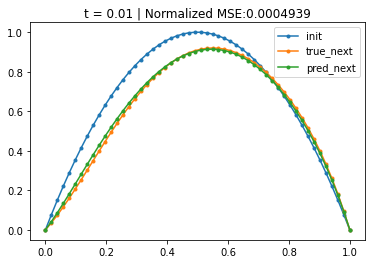

In [99]:
# Initial condition
plt.plot(Xfull,ad_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,ad_sol(Xfull,h,beta,c,n),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings
nmse = mean_squared_error(u_next,ad_sol(Xfull,h,beta,c,n))/mean_squared_error(0*ad_sol(Xfull,h,beta,c,n),ad_sol(Xfull,h,beta,c,n))
plt.title('t = {} | Normalized MSE:{}'.format(h, round(nmse,7)))
plt.legend()
plt.show()

Health checks:
- If we use `h = 0` then the analytical, kernel and initial functions agree.
- If we use `c = 0` (to get advection only) we get an error since the analytical solution is expressed with c in the denominator. Is it worth it to implement the transport equation in 1D ?
- If we use `beta = 0` (to get difussion only) we observe a good behaviour.

## Let's take small steps 

Say we want to get to `t=0.2` by taking `h = 0.01`

In [100]:
t = 0.15
steps = int(t//h)
# Initialize at the initial condition
uprev = u0
for _ in range(steps):
    y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
    sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)
    u_next = np.dot(Kphi.T,sol)
    # update
    uprev = u_next[1:-1]

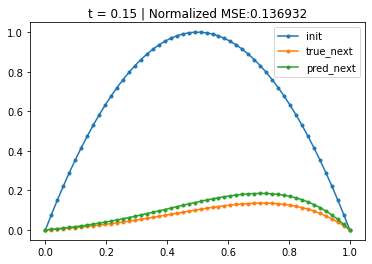

In [101]:
plt.figure()
# Initial condition
plt.plot(Xfull,ad_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,ad_sol(Xfull,t,beta,c,20),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings
nmse = mean_squared_error(u_next,ad_sol(Xfull,t,beta,c,20))/mean_squared_error(0*ad_sol(Xfull,t,beta,c,20),ad_sol(Xfull,t,beta,c,20))
plt.title('t = {} | Normalized MSE:{}'.format(t, round(nmse,7)))
plt.legend()
plt.show()

In [102]:
# Study converge as we increase solution of points. DONE
# Try Matern kernels, to see if we can get rid of regularization. 
# Add advection term. DONE

## Convergence

In [105]:
mses = []
sup_norms = []
l2_norms = []
L2_norms = []
for n in range(2,13):
    # X_full
    Xfull = np.linspace(0,1,2**n+2)
    delta = Xfull[1]-Xfull[0]
    #print(delta)
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = ad_u0(Xomega)
    # Advection coefficient
    beta = 5
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 0.01

    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, beta, c, k = 'Gaussian', k_param = k_param)
    y_prev = jnp.concatenate((u0,np.zeros((len(Xboundary)),)))

    R = jnp.diag(jnp.diag(Kphiphi))
    sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)

    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, beta, c, k = 'Gaussian', k_param = k_param)
    u_next = np.dot(Kphi.T,sol)
    # Vector of differences
    u_true = ad_sol(Xfull,h,beta,c,5)   
    f = np.abs(u_next - u_true)**2
    # sup norm
    #sup_norms.append(f/np.max(ad_sol(Xfull,h,beta,5)))
    # l2 norm
    #l2_norms.append(norm(u_next - ad_sol(Xfull,h,beta,5),ord=2)/norm(ad_sol(Xfull,h,beta,5),ord=2))
    L2_norms.append(trap(f,delta))
    print(trap(f,delta))
    #nmse = mean_squared_error(u_next,ad_sol(Xfull,h,beta,5))/mean_squared_error(0*ad_sol(Xfull,h,beta,5),ad_sol(Xfull,h,beta,5))
    #mses.append(nmse)

0.00026368677080785207
0.00023718904043423935
0.0002157692483849504
0.0002126953933330751
0.00021083644648035713
0.00020863282200343065
0.00020684966193960737
0.00020710333698433157
0.00021059259677004896
0.0002174322681471614
0.0002275442205066931


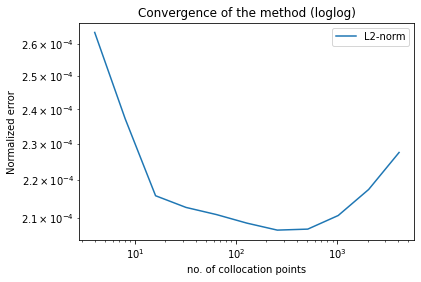

In [106]:
xrange = 2**np.arange(2,13)
#plt.loglog(xrange,sup_norms, label = 'sup-norm')
plt.loglog(xrange,L2_norms,label = 'L2-norm')
#plt.loglog(xrange,mses,label = 'mse')
plt.xlabel('no. of collocation points')
plt.ylabel('Normalized error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

- Try the method for higher dimensions, say 5. Invert $k(\phi,\phi)$ using the polylog rates.
- Compute the L^2 norm usind trapezoidal rule. Use in the x-axis dx.
- Use the domain [-3,3] for the next example.

- Convergence plots for multiple time steps ! 